#### Libraries

In [1]:
# Standard
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Sklearn
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

#### Settings

In [28]:
# Display all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Notebook random state
random_state = 421

# Set visuals to default
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Device
# folder = 'C:/Users/nuke2/Desktop/NW Work/Data/421/hw02/U.S._Chronic_Disease_Indicators__CDI_.csv' # Desktop
folder = 'C:/Users/Sam/Desktop/NW Work/DATA/421/hw02/U.S._Chronic_Disease_Indicators__CDI_.csv' # Laptop

# Question 2

#### Generate Data

In [3]:
# Set variables for simulated data
n_features = 15
n_classes = 3
n_informative = 6

# Generate random multidimensional data with 1000 samples and 15 features
X_2, y_2 = make_classification(n_samples=1000, 
                               n_features=n_features,
                               n_classes=n_classes,
                               n_informative=n_informative,
                               random_state=random_state)

### Build a K-means function from scratch (without using sklearn) and make assumptions to simplify the code as needed

In [4]:
# Initialize random centroids
def random_centroids(X, k, random_state=random_state):
    random.seed(random_state)
    num_samples, num_features = X.shape
    centroids = X[np.random.choice(num_samples, k, replace=False), :]
    return centroids

# Find distances for each point
def find_distance(X, k, centroids):
    num_samples, num_features = X.shape
    distances = np.zeros((num_samples, k))
    for cluster in range(k):
            distances[:, cluster] = np.linalg.norm(X - centroids[cluster, :], axis=1)
    return distances

# Assign labels to all points
def assign_labels(distances):
    cluster_assignment = np.argmin(distances, axis=1)
    return cluster_assignment

# Updates centroids for each cluster
def update_centroids(X, labels, k, centroids):
    for cluster in range(k):
            centroids[cluster, :] = np.mean(X[labels == cluster, :], axis=0)
    return centroids

# K-means from scratch function
def kmeans_scratch(data, k, max_iter=100, random_state=random_state):
    random.seed(random_state)
    
    # Init random centroids
    centroids = random_centroids(data, k)
    centroids_old = centroids.copy()
    
    for iteration in range(max_iter):
        # Calculate distances for each point
        distances = find_distance(data, k, centroids)
        # Get labels
        labels = assign_labels(distances)
        # Update centroids
        centroids = update_centroids(data, labels, k, centroids)
        
        if np.array_equal(centroids, centroids_old):
            break
            
        centroids_old = centroids.copy()
    
    return labels, centroids

### Use the elbow method to find an appropriate value for k

In [5]:
def elbow_plot(data):
    # Set the range of k values to try
    k_range = range(1, 11)

    # Initialize an empty list to store the WSS values for each k
    wss_values = []

    # Compute the WSS values for each k
    for k in k_range:
        # Run K-Means clustering with the current value of k
        labels, centroids = kmeans_scratch(data, k)

        # Compute the sum of squared distances of samples to their closest cluster center
        distances = find_distance(data, k, centroids)
        wss = np.sum(np.min(distances, axis=1) ** 2)
        wss_values.append(wss)

    # Plot the WSS values vs. k
    plt.plot(k_range, wss_values, 'o-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-cluster Sum of Squares (WSS)')
    plt.title('Elbow method for optimal k')
    plt.show()

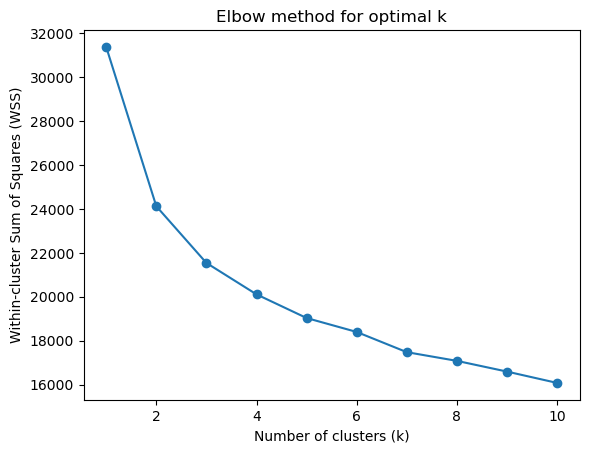

In [6]:
elbow_plot(X_2)

k=3 looks to be a good elbow point

### Use the silhouette plot to evaluate your clusters

In [7]:
def plot_silhouettes(data, labels, k):    
    # Compute the silhouette score for the clustering result
    silhouette_avg = silhouette_score(data, labels)

    # Compute the silhouette values for each sample
    silhouette_values = silhouette_samples(data, labels)

    # Set up the plot
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 4)

    # Set the color map for the plot
    cmap = cm.get_cmap("nipy_spectral")

    # Plot the silhouette values for each sample
    y_lower = 10
    for i in range(k):
        # Check for empty clusters
        if np.sum(labels == i) == 0:
            continue

        # Aggregate the silhouette values for samples in cluster i
        cluster_silhouette_values = silhouette_values[labels == i]
        cluster_silhouette_values.sort()
        cluster_size = cluster_silhouette_values.shape[0]
        y_upper = y_lower + cluster_size

        # Set the color for the current cluster
        color = cmap(float(i) / k)

        # Fill in the silhouette plot for the current cluster
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plot with the cluster number at the middle
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10

    # Set the plot properties
    ax.set_title(f"Silhouette plot k={k}")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    plt.show()

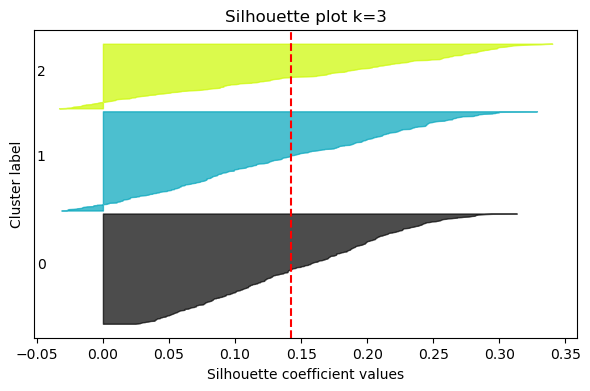

In [8]:
k=3
plot_silhouettes(X_2, kmeans_scratch(X_2, k)[0], k)

The clusters look to be alright. There are not many negative Silhouette coefficient values which indicates we may have found the best clusters. 

### Re-cluster the data to see if you can improve your results

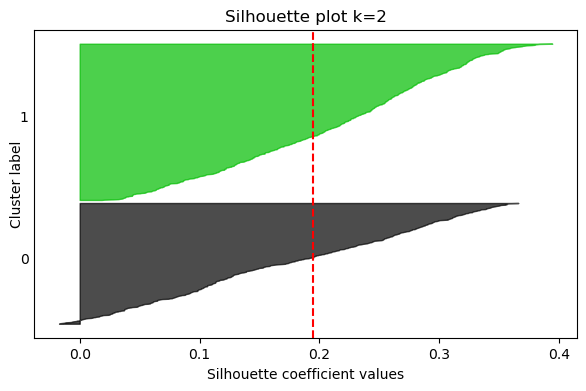

In [9]:
k=2
plot_silhouettes(X_2, kmeans_scratch(X_2, k)[0], k)

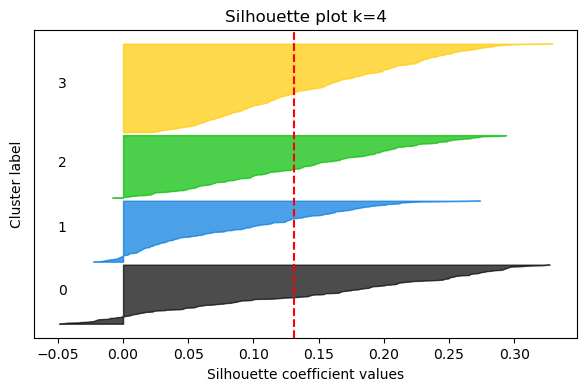

In [10]:
k=4
plot_silhouettes(X_2, kmeans_scratch(X_2, k)[0], k)

As we can see above, there seem to be good results for k=2 and poor results for k=4. k=2 only has a few negative silhouette values while k=4 has many negative silhouette values.

### Perform PCA on the original dataset and retain the most important PCs.

In [11]:
# 3 components seem to explain most of the variance hence n_components=5
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_2)

### Run K-means on the PCA output, compare results with respect to cluster quality and time taken

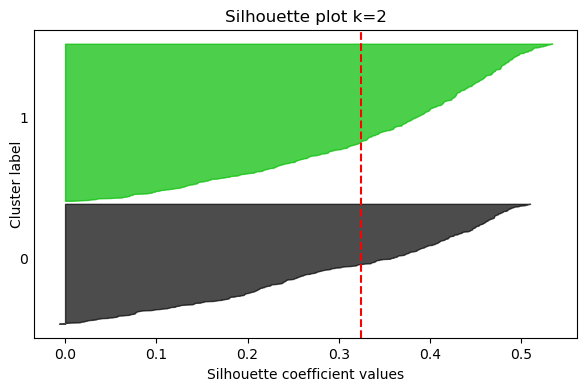

In [12]:
k=2
plot_silhouettes(X_pca, kmeans_scratch(X_pca, k)[0], k)

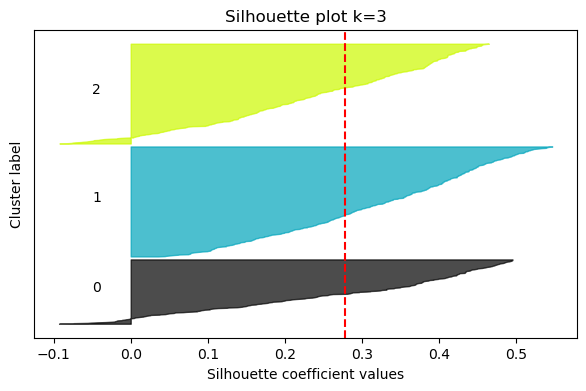

In [13]:
k=3
plot_silhouettes(X_pca, kmeans_scratch(X_pca, k)[0], k)

After looking at the results we can see clustering with two groups performs better when using the three most important principal components, while clustering with three groups performs worse.

# Question 3

In [31]:
# Read data
df_3 = pd.read_csv(folder, low_memory=False)
df_3.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,GeoLocation,ResponseID,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,916,916.0,NaN,NaN,NaN,NaN,Gender,Male,NaN,NaN,NaN,NaN,POINT (-92.27449074299966 34.74865012400045),NaN,5,AST,AST3_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,2227,2227.0,NaN,NaN,NaN,NaN,Overall,Overall,NaN,NaN,NaN,NaN,POINT (-106.13361092099967 38.843840757000464),NaN,8,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,708,708.0,NaN,NaN,NaN,NaN,Overall,Overall,NaN,NaN,NaN,NaN,POINT (-77.036871 38.907192),NaN,11,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,3520,3520.0,NaN,NaN,NaN,NaN,Gender,Female,NaN,NaN,NaN,NaN,POINT (-83.62758034599966 32.83968109300048),NaN,13,AST,AST3_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,123,123.0,NaN,NaN,NaN,NaN,Race/Ethnicity,Hispanic,NaN,NaN,NaN,NaN,POINT (-84.71439026999968 44.6613195430005),NaN,26,AST,AST3_1,NMBR,RACE,HIS,NaN,NaN,NaN,NaN


### Data Transformation

In [43]:
# Retain a limited subset of the data for the year 2020
df_3_filtered = df_3[(df_3.YearStart == 2020)]

# Retain a limited subset of Topics (e.g., Alcohol, Diabetes, Cancer, etc.)
df_3_filtered = df_3_filtered[(df_3_filtered.Topic == 'Diabetes')]

# Retain a limited subset of Questions
df_3_filtered = df_3_filtered[(df_3_filtered.Question == 'Mortality with diabetic ketoacidosis reported as any listed cause of death')]

In [51]:
df_3_filtered.groupby('StratificationCategory1').count()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,Stratification1,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,GeoLocation,ResponseID,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
StratificationCategory1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Gender,306,306,306,306,306,306,306,0,306,306,225,225,81,81,150,150,306,0,0,0,0,306,0,306,306,306,306,306,306,0,0,0,0
Overall,156,156,156,156,156,156,156,0,156,156,141,141,15,15,94,94,156,0,0,0,0,153,0,156,156,156,156,156,156,0,0,0,0
Race/Ethnicity,765,765,765,765,765,765,765,0,765,765,240,240,525,525,160,160,765,0,0,0,0,765,0,765,765,765,765,765,765,0,0,0,0
